# garfield++ 
## STHWELL simulation with COMSOL
### Set environment

In [1]:
import ROOT
import os, sys
import ctypes
import math
import time
import random

Welcome to JupyROOT 6.30/04


In [2]:
# access garfield++ nightly build
path = os.path.expandvars('$ROOT_LCG_VIEW_PATH/$ROOT_LCG_VIEW_NAME/$ROOT_LCG_VIEW_PLATFORM')
print("path for Garfield++ software: ", path) 
ROOT.gSystem.Load(path + '/lib64/libmagboltz.so')
ROOT.gSystem.Load(path + '/lib64/libGarfield.so')
os.environ['HEED_DATABASE'] = path + '/share/Heed/database'

path for Garfield++ software:  /cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt


### Set gas data

In [3]:
gas = ROOT.Garfield.MediumMagboltz(); 

## Create gas medium
#gas.SetComposition("ar", 93., "co2", 7.); 
#gas.Initialise();
## Set temperature [K] and pressure [Torr].
#gas.SetPressure(3 * 760.);
#gas.SetTemperature(293.15);

#gas.SetFieldGrid(100., 100.e3, 20, True);
#ncoll = 10; # multiples of 10^7
#gas.GenerateGasTable(ncoll);
#gas.WriteGasFile("ar_93_co2_7.gas");

# Load gas medium
gas.LoadGasFile("./gas_files/ar_93_co2_7.gas")

mediumView = ROOT.Garfield.ViewMedium()
mediumView.SetMedium(gas)
#mediumView.PlotElectronVelocity('e')


MediumMagboltz::LoadGasFile:
    Reading file ./gas_files/ar_93_co2_7.gas.
    Version 12.
    Gas composition set to Ar/CO2 (93/7).


### Load mesh, materials and voltage map files

In [4]:
# initialize COMSOL component
cmp_STHWELL = ROOT.Garfield.ComponentComsol()
cmp_STHWELL.Initialise("./COMSOL_files/241024_SWELL_Vth1000_Vd150_mesh_second-order.mphtxt",
                "./COMSOL_files/241022_SWELL_Vth1000_Vd150_materials_test_all_eps_to1.txt",
                "./COMSOL_files/241024_SWELL_Vth1000_Vd150_potential.txt", 
                "m")

True

ComponentComsol::Initialise: 1326873 nodes.
ComponentComsol::Initialise: 984177 elements.
ComponentComsol::Initialise: Reading potentials.
ComponentComsol::Prepare:
    Caching the bounding boxes of all elements... done.
    Initialized tetrahedral tree.

ComponentComsol::Initialise: Done.


### Set gas volume and check material parameters

In [5]:
# Assign gas medium
nMaterials = cmp_STHWELL.GetNumberOfMaterials() 
for i  in range(nMaterials):
  eps = cmp_STHWELL.GetPermittivity(i);
  if i == 2: # i=2 ->is gas
    cmp_STHWELL.SetMedium(i, gas); #Assign medium
    print("Medium " + " " + str(i) + " (eps = " + str(eps) + " ) set to Magboltz gas.")

cmp_STHWELL.PrintMaterials();

Medium  2 (eps = 1.0 ) set to Magboltz gas.
ComponentComsol::PrintMaterials:
    Currently 3 materials are defined.
      Index Permittivity  Resistivity Notes
          0            1           -1 (drift medium)
          1            1           -1
          2            1           -1 Ar/CO2, drift medium, ionisable


### Visualize field

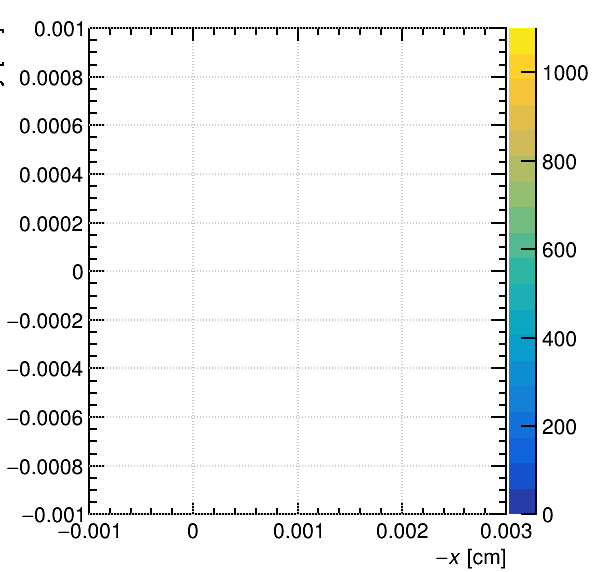

In [6]:
fieldView = ROOT.Garfield.ViewField();
fieldView.SetComponent(cmp_STHWELL)
fieldView.SetPlane(0, 0, -1, 0., 0., 0.0056);
fieldView.SetArea(-0.001, -0.001, 0.003, 0.001);
fieldView.SetVoltageRange(0., 1100.);
#TCanvas* cf = new TCanvas("cf", "", 600, 600);
#cf.SetLeftMargin(0.16);
#fieldView.SetCanvas(cf);
fieldView.PlotContour("v");

### Visualize mesh

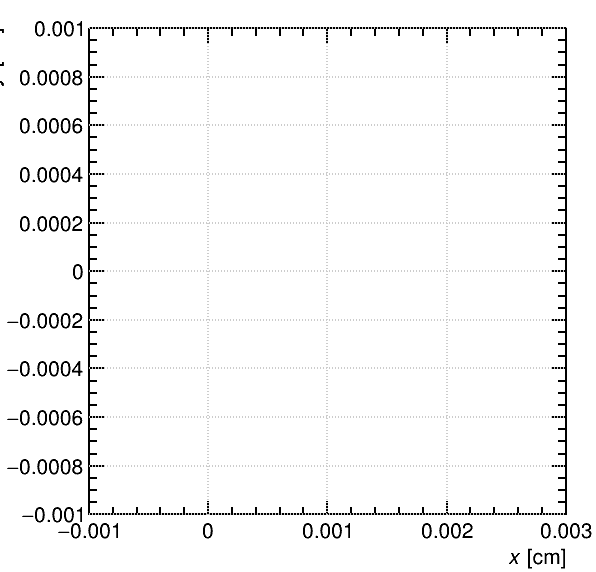

In [7]:
driftView = ROOT.Garfield.ViewDrift()
meshView = ROOT.Garfield.ViewFEMesh()
meshView.SetComponent(cmp_STHWELL)
meshView.SetPlane(0, 0, -1, 0., 0., 0.0056) 
meshView.SetFillMesh(True);
meshView.SetArea(-0.001, -0.001, 0.003, 0.001)
meshView.SetColor(0, ROOT.kRed + 3);
meshView.SetColor(1, ROOT.kBlue + 3);
meshView.SetColor(2, ROOT.kYellow + 3);
meshView.EnableAxes();
meshView.SetViewDrift(driftView);
meshView.Plot();